<a href="https://colab.research.google.com/github/scrameri/Umweltbiologie/blob/master/Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install packages
This Jupyter notebook is based on the programming language [`R`](https://www.r-project.org/about.html) and has been tested on `R` version 3.6.3.

Author: [Simon Crameri](https://peg.ethz.ch/people/person-detail.MTYzNTY1.TGlzdC80MzUsLTczMzM3Mzg4Ng==.html), ETH Zurich, May 2020

Note: commands are sometimes wrapped in a `print` call. This is just to ensure a `R`-console-like print output, and is generally not needed. Comments are sometimes wrapped in a `cat` call, just to label the outputs of multi-line chunks of code.

In [1]:
need.pckg <- c("GGally","ggplot2","EnvStats","multcomp") # needed for this script
if (any(!need.pckg %in% installed.packages())) {
  for (i in need.pckg[!need.pckg %in% installed.packages()]) {
    cat("installing", i, "...\n")
    install.packages(i)
  }
}

installing GGally ...


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘reshape’




installing EnvStats ...


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘nortest’




installing multcomp ...


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’




### 1.1 Load libraries

In [2]:
library("GGally") # for ggpairs()
library("ggplot2") # for ggplot()
library("EnvStats") # for qqPlot()
library("multcomp") # for glht()

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm


The following object is masked from ‘package:base’:

    print.default


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:EnvStats’:

    boxcox



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




ERROR: ignored

***
## 2. Read the data

In [0]:
# dataset for Data Exploration and ANOVA and Linear Models
morph <- read.csv("https://raw.githubusercontent.com/scrameri/Umweltbiologie/master/Anova_LM.csv")

# datset for Multivariate Analyses
d.mis <- read.csv("https://raw.githubusercontent.com/scrameri/Umweltbiologie/master/Multivariate.csv", row.names = "ID")

**Note**: the `.csv` file uses `,` rather than ; as field separators, which can cause troubles when opening the file in Excel on Mac. You can also save a version separated with `;`, but you will then need to set `sep = ";"`, because the default argument is `read.csv(file, sep = ",", dec = ".")`. There is the complementary `read.csv2` function with default argument `read.csv2(file, sep = ";", dec = ",")`.



### 2.1 The *Dianthus* dataset (`morph`)

In [0]:
str(morph)

The `morph` dataset contains morphological measurements of eight populations of [*Dianthus carthusianorum*](https://www.infoflora.ch/de/flora/dianthus-carthusianorum.html) taken in Summer 2015 in Wallis (Switzerland). Populations were located in two classes of elevation (4 high, 4 low elevation).

A few facts about [*D. carthusianorum*](https://de.wikipedia.org/wiki/Kart%C3%A4usernelke):
- Karthäuser-Nelke in German, family Caryophyllaceae like *Silene*
- native to Middle Europe, in dry habitats from colline to alpine (introduced to N America) 
- [gynodioecious](https://en.wikipedia.org/wiki/Gynodioecy), meaning that there are female and hermaphroditic individuals
- perennial (or biennial), meaning that plants survive winter as rosettes or seeds
- insect-pollinated
- parasite: fungus [*Microbothryum*](https://fr.wikipedia.org/wiki/Microbotryum) *dianthorum* (anther smut fungus) that causes sterility and is transmitted by pollinators

A few facts about the dataset:
- ID: individual ID
- Population: population ID
- Elevation: elevation class
- Date: measurement date
- Infection: whether a plant was [infected](https://upload.wikimedia.org/wikipedia/commons/e/ef/Microbotryum_dianthorum_Dianthus_sp._2019_07_18_05.jpg) or healthy
- Sex: whether a plant was hermaphroditic or female
- Stalk_height: mean stalk height per plant (mm)
- Stalk_count: number of stalks per plant
- Bud_count: number of buds per plant
- Flower_count: number of open flowers per plant
- Flower_diam: flower (corolla) diameter (mm)
- Petal and Sepal lengths and widths (mm)
- Rosette_diam1: diameter of first rosette (mm) - only recorded at high elevation
- Rosette_diam2: diameter of second rosette (mm) - only recorded at high elevation

The experimental design and measurements have been done by [Ursina Walther](https://peg.ethz.ch/people/person-detail.html?persid=158239) (a PhD student in our group). She was interested in studying the evolution of floral traits in this species, especially in relation to the interaction between the plants and their Microbothryum parasite.

### 2.2 The *Dalbergia* dataset (`d.mis`)

In [0]:
str(d.mis)

cat("\nrownames:\n")
print(head(rownames(d.mis)))

The `d.mis` dataset contains morphological measurements of 10 leaf characters in eight [*Dalbergia*](https://www.gbif.org/occurrence/gallery?country=MG&taxon_key=2968358) [rosewood](https://en.wikipedia.org/wiki/Rosewood) species from Madagascar. 
 
A few facts about the dataset:
- ID: individual ID (already assigned to the `rownames` of the data)
- Species: species ID (dummy)
- leaf.length: length of leaf petiole and rachis (without terminal leaflet) in mm
- leaflet.length: length of a leaflet im mm
- leaflet.width: length of a leaflet in mm
- leaflet.area: area in $mm^2$
- leaflet.upper.hairy: hairiness score of upper leaflet surface (1 = glabrous, 2 = sparsely pubescent, 3 = densely pubescent)
- leaflet.lower.hairy: same for lower leaflet surface
- leaf.hairy: same for leaf rachis and petiole
- leaflet.shape1: principal leaflet shape component 1 (see [Momocs](https://vbonhomme.github.io/Momocs/) package)
- leaflet.shape2: principal leaflet shape component 2 (another aspect of shape)
- length.width: leaflet length-to-width ratio

All but the hairiness scores are median values over multiple measurements per individual.

***
## 3. Data Exploration


We will use the `morph` data set here.

In [0]:
morph <- read.csv("https://raw.githubusercontent.com/scrameri/Umweltbiologie/master/Puzzle_ANOVA_LM.csv")

Before starting any analysis, always check that the data was read in correctly using `str`.

In [0]:
str(morph)

The `dim` and `summary` function are also quite useful to get a first overview.

In [0]:
print(dim(morph)) # gives both nrow() and ncol() of the dataset


In [0]:
summary(morph$Stalk_height) # gives a summary for one variable

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
 Based on what you now know about the study and the data:
- what are the response variable(s)?
- what are the explanatory variable(s)?

***

### 3.1 Plot the data
There are various plotting techniques to visualize data. Some people prefer the `R` base graphics, others learn the grammar of graphics implemented in [`ggplot2`](https://ggplot2.tidyverse.org/). For this practical, both approaches can be used. These are the basic functions for the most important plots, shown for `R` base graphics and `ggplot2` graphics:

#### 3.1.1 Scatterplot
Use **Scatterplots** to plot two numeric variables (classes `num` for continuous, or `int` for discrete data) against each other. Scatterplots can be more informative if different *symbols* or *colours* for an additional factor, or *sizes* or *transparency* for an additional numeric variable are used.

In [0]:
# base
plot(Sepal_length ~ Petal_length, data = morph)

In [0]:
# ggplot2
ggplot(data = morph, aes(x = Petal_length, y = Sepal_length)) + geom_point()

#### 3.1.2 Boxplot
Use **Boxplots** to plot a numeric variable against a categorical variable (class `factor`). Boxplots are *summarizing* the data. By default, the **box** is the [*interquartile range*](https://en.wikipedia.org/wiki/Interquartile_range) and contains 50% of the data points, while the **whiskers** extend to "the most extreme *data point* which is no more than 1.5 times the interquartile range from the box" (see red and blue lines for 1.5 times the interquartile range from the box). If you have less than eight data points per factor level, you might just as well plot all the data points using `stripchart`.

In [0]:
# base
boxplot(Sepal_length ~ Elevation, data = morph, ylim = c(8,20))

# understand interquartile range (iqr): range from 25% to 75% quantiles, contains 50% of the data
iqr1 <- quantile(morph$Sepal_length[morph$Elevation=="high"], c(0.25,0.75))
iqr2 <- quantile(morph$Sepal_length[morph$Elevation=="low"], c(0.25,0.75))

# whiskers extend to the most extreme data point not exceeding 1.5*iqr from the box (by default)
whisker1 <- iqr1 + c(-1.5,1.5)*diff(iqr1)
whisker2 <- iqr2 + c(-1.5,1.5)*diff(iqr2)

segments(0.5, whisker1, 1.5, whisker1, col = "tomato")
segments(1.5, whisker2, 2.5, whisker2, col = "blue")

# stripchart for few data points
stripchart(Sepal_length ~ Elevation, data = subset(morph, Sex == "female"), vertical = TRUE)

In [0]:
# ggplot2
ggplot(data = morph, aes(x = Elevation, y = Sepal_length)) + geom_boxplot()

#### 3.1.3 Histogram
Use **Histograms** to plot a variable's distribution. The `breaks` argument in `hist` and the `bins` argument in `geom_histogram` can be used to fine-tune the binning of values into histogram categories. Try and play around with it.

In [0]:
hist(morph$Sepal_length, breaks = 20)

In [0]:
ggplot(data = morph, aes(x = Sepal_length)) + geom_histogram(bins = 20) 

#### 3.1.4 Barplot
Use **Barplots** to plot all values of a single variable or a table of counts.

In [0]:
# base
barplot(table(morph$Population))

In [0]:
# ggplot2 (uses count table by default!)
ggplot(data = morph, aes(x = Population)) + geom_bar(stat = "count")

#### 3.1.5 Mosaic Plot and Stacked Barplot
Use **Mosaic Plots** or **Stacked Barplots** to plot *contingency tables* of two categorical variables against each other. In a Mosaic Plot, the relative size of each mosaic is proportional to the number of observations with a given factor level combination. The stacked barplot is slightly different, once shown as stacked *counts* and once as stacked *proportions*.

In [0]:
# base
mosaicplot(table(morph$Elevation,morph$Infection), main = "Mosaic Plot")

In [0]:
# ggplot2 (fill variable determines the stacking)
ggplot(morph, aes(x = Elevation, fill = Infection)) + 
  geom_bar() + 
  ggtitle("Stacked Barplot")
  
ggplot(morph, aes(x = Elevation, fill = Infection)) + 
  geom_bar(position = "fill") + labs(y = "Proportion") +
  ggtitle("Stacked Barplot")

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you produce a plot of `Petal_length ~ Sepal_length` with points color-coded for `Infection` and size proportional to `Petal_length`?


In [0]:
# Make your plot here

***
### 3.2 Generate all pairwise plots
#### Use regular expressions
Given that we have 17 variables, plotting all of them against each other by hand would be tedious. For datasets with a moderate number of variables, you can use the `ggpairs` function from the [*GGally*](https://cran.r-project.org/web/packages/GGally/index.html) package to get a graphical overview over many variables at once with a single line of code. The function produces all possible pairwise plots, minimizes redundancy and takes care of factors and numerical variables automatically.

With 17 variables, plotting all against all would lead to too many (289) plots on a single page. Let us therefore subset the variables. You can use `grep` and [**regular expressions**](https://regex101.com/) to find the indices of certain variable names, this often saves code.

In [0]:
# this returns the index of variable names *starting* with 'Flower' (^ specifies the *start*)
grep(pattern = "^Flower_", x = names(morph))

In [0]:
# this returns the index of variable names *ending* with either 'length' or 'width' ($ specifies the *end*, | is a logial <or>)
grep(pattern = "length$|width$", x = names(morph)) 


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you identify the indices of columns with variables of *fertile* structures (buds, flowers) using a regular expression?

In [0]:
# Create your regular expression here
names(morph)
grep(pattern = "XXX", x = names(morph))

#### print all pairwise plots

In [0]:
print(vars.fertile <- names(morph)[grep(pattern = "^Flower|^Bud|^Petal|^Sepal", x = names(morph))])
print(vars.sterile <- names(morph)[grep(pattern = "^Stalk|^Rosette", x = names(morph))])

The `ggpairs` function prepares the pairwise plots as `gg` class objects. These can then be printed to the plotting device, or saved to a PDF file by enclosing the print commands between the `pdf` and `graphics.off` functions.

It is more reproducible (and therefore more scientific) to save plots with such code rather than by manually exporting a plot from R Studio. The specified `height` and `width` also prevents the saved plot to be smaller or larger depending on your device size.

In [0]:
pairs.fertile <- ggpairs(data = morph, columns = c("Population","Elevation","Infection","Sex", vars.fertile))
pairs.sterile <- ggpairs(data = morph, columns = c("Population","Elevation","Infection","Sex", vars.sterile))

In [0]:
#pdf("Pairsplots.pdf", height = 15, width = 15)
#pairs.sterile # or print(pairs.sterile)
pairs.fertile # or print(pairs.fertile)
#graphics.off()

Does everything look all right?




***
### 3.3 Handle obvious data errors
If there are obvious data errors, you could of course just fix the original data table. But such a fixes are *not transparent*, and usually *not documented* anywhere.

You can be more **transparent** by handling (replacing, deleting) obvious data errors in the analysis script. This makes such data changes **documented** and **reproducible**. 

If you can reconstruct the correct value (e.g. because it is just a comma error), do so in the script. If you cannot reconstruct what happened with an impossible data value, you should set it to `NA` or remove the entire data row in the analysis script. Make sure to fix errors before the final analyses are carried out.

In [0]:
# get index
morph$Flower_diam[morph$Flower_diam > 100] # Dianthus with 185 mm flower diameter is impossible

# correct an obvious comma error
morph$Flower_diam[morph$Flower_diam > 100] <- morph$Flower_diam[morph$Flower_diam > 100]/10

# set an impossible data value to NA
# morph$Flower_diamesser[morph$Flower_diamesser > 100] <- NA

***

### 3.4 Check the probability distribution
Knowing which [probability distribution](https://en.wikipedia.org/wiki/Probability_distribution) best represents your variables is important because [statistical models](https://en.wikipedia.org/wiki/Statistical_model) such linear models make certain **assumptions** on the probability distribution of the response variable or the model residuals (see Chapter 4). You have already seen that the **histogram** is a good visualization of a variable's probability distribution, and deviations from a normal distribution become intuitively apparent.

The first thing to bear in mind is that there are **continuous** probability distributions (for continuous variables) and **discrete** probability distributions (for counts).

Let us look at `Stalk_count`, which is a non-negative [count](https://en.wikipedia.org/wiki/Count_data) variable and therefore by definition bound by zero on the left, and unbounded on the right. Non-negative counts are usually assumed to follow a [**Poisson distribution**](https://en.wikipedia.org/wiki/Poisson_distribution), but not all count data can be well represented by a Poisson distribution. In some cases, a variable [transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) (often the square-root) might help to represent the counts as a continuous variable to fit an appropriate model (see Chapter 4.7), but the model parameters will be difficult to interpret.

More often, [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) tests are used, such as the [Kruskal-Wallis-test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) which does not assume that the variable (or residuals) follows a Poisson or Normal distribution.

If you want to get to know your variables, you can try to represent any variable with a statistical distribution using **simulations**, and compare your data against data from a specific statistical distribution, parametrized to match your data as closely as possible. The `R` package [*EnvStats*](https://cran.r-project.org/web/packages/EnvStats/index.html) allows for simulation of different probability distributions from your data, and comparison of these against your data in so-called **Q-Q Plots** (Quantile-Quantile plots) using the `qqPlot` function.

Let us now look at a discrete variable (`Stalk_count`) and a continuous variable (`Flower_diam`) for comparison, and simulate some probability distributions.

In [0]:
# see this help page for a comprehensive list of continuous and discrete distributions
# ?EnvStats::Distribution.df

# mean and variance
cat("\nStalk_count mean:\n")
print(mean(morph$Stalk_count))

cat("\nStalk_count variance:\n")
print(var(morph$Stalk_count))

# simulate and compare
par(mfrow=c(2,3))
hist(morph$Stalk_count, breaks = 20, col = "tomato")

# simulate Poisson distribution for counts
qqPlot(morph$Stalk_count, distribution = "pois", estimate.params = TRUE, add.line = TRUE, points.col = "tomato", main = "Poisson Q-Q Plot")

# simulate Exponential distribution on square-root-transformed counts
qqPlot(sqrt(morph$Stalk_count), distribution = "exp", estimate.params = TRUE, add.line = TRUE, points.col = "tomato", main = "Exponential Q-Q Plot")

hist(morph$Flower_diam, breaks = 20, col = "cadetblue")

# simulate normal distribution for continuous variables
qqPlot(morph$Flower_diam, distribution = "norm", estimate.params = TRUE, add.line = TRUE, points.col = "cadetblue", main = "Normal Q-Q Plot")

# simulate normal distribution for log-transformed variable (so-called log-normal distribution)
qqPlot(log(morph$Flower_diam), distribution = "norm", estimate.params = TRUE, add.line = TRUE, points.col = "cadetblue", main = "Normal Q-Q Plot")

par(mfrow=c(1,1))

As with any Q-Q plot, a variable can be represented by a given distribution if the sample [quantiles](https://en.wikipedia.org/wiki/Quantile) (the variable's values) follow the theoretical quantiles (simulated from a given probability distribution). 

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Which method would you use to test for differences in `Stalk_count`? 
- Which method would you use to test for differences in `Flower_diam`? 

***
## 4 Statistical Tests

### 4.1 Parametric tests of difference

A [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) is a [**parametric**](https://en.wikipedia.org/wiki/Parametric_statistics) test, which means that the variable to be tested is assumed (and modeled) to follow some defined probability distribution. The t-test assumes *normally* distributed data.

In [0]:
# one-sample t-test
t.test(morph$Sepal_length)

# two-sample t-test
t.test(Sepal_length ~ Elevation, data = morph)

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What are the null and alternative hypotheses? 
- What is the test result?

***
### 4.2 Non-parametric tests of difference
If the assumption of normality is not met, you should **not** do a t-test. For such cases, there are [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) tests that make fewer assumptions on distributions.

A powerful example is the [Mann-Whitney test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test), which is the unpaired version of the [Wilcoxon Rank Sum test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) for paired (dependent) data.

In [0]:
# one-sample test
wilcox.test(morph$Sepal_length)

# two-sample test
wilcox.test(Sepal_length ~ Elevation, data = morph)

But what if there are more than two groups? The [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) helps here, and can be seen as the non-parametric alternative to a one-way ANOVA.

In [0]:
# Kruskal-Wallis test
kruskal.test(Sepal_length ~ Population, data = morph)

***
### 4.3 Correlation tests
Correlation tests are used to test a **relationship** between two continuous variables rather than a difference. Again, there is a parametric and a non-parametric version.

The parametric version is based on **Pearson's correlation**, which assumes a *linear* relationship. The test is therefore related to a linear regression. If the relationship is not linear, you should **not** compute Pearson's correlation but use a [*rank correlation*](https://en.wikipedia.org/wiki/Rank_correlation). One such rank correlation is **Spearman's correlation**. 

The computed [correlation coefficient](https://en.wikipedia.org/wiki/Correlation_coefficient) is a number between -1 (perfect negative correlation) and +1 (perfect positive correlation). The nearer to zero the coefficient gets, the weaker the correlation.

**Note** the different `formula` notation (~ X1 + X2) compared to the tests of difference (Y ~ X).

In [0]:
# parametric correlation test
# cor.test(morph$Sepal_length, morph$Petal_length) # equivalent
cor.test(~ Sepal_length + Petal_length, data = morph)

# non-parametric correlation test
cor.test(~ Sepal_length + Petal_length, data = morph, method = "spearman")

# compare with linear regression model and scatterplot
cat("\n        Linear regression:\n")
summary(mod <- lm(Petal_length ~ Sepal_length, data = morph))
ggplot(data = morph, aes(x = Sepal_length, y = Petal_length)) + 
  geom_point() +
  geom_abline(intercept = coef(mod)[1], slope = coef(mod)[2], colour = "tomato") +
  theme_bw()

***

## 5. Analysis of Variance and Linear Regression Models

### 5.1 The relationship between t-test, ANOVA and linear regression models

[**Analysis of Variance (ANOVA)**](https://en.wikipedia.org/wiki/Analysis_of_variance) and [**linear regression models** (linear models)](https://en.wikipedia.org/wiki/Linear_regression) sound scary to some or fancy to others. There is no space to introduce these methods properly, they are usually taught in one or several semesters of study. I will therefore try to explain them as extensions of a well-known test, the [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test). An example two-sample t-test is the test for difference in human height between two sexes.

How do ANOVA and linear models extend the t-test? In short, they allow for testing the effect of a **predictor** (a.k.a. independent variable, input variable, X variable, e.g. sex) on a dependent variable (a.k.a. **response** variable, dependent variable, output variable, measure variable, Y variable, e.g. human height) even if the predictor has more than two factor levels, and even if there is more than one predictor.

In `R`, ANOVA can be carried out using the function `aov`, while linear models can be fitted using the function `lm` or `glm` (for generalized linear models). 

ANOVA is used to compare within-group and between-group [variance](https://en.wikipedia.org/wiki/Variance) in a continuous variable of interest (the response variable). It tests the null hypothesis that that the mean of the response variable is the same in each group. That test is done by computing the ratio of between-group variance (MS<sub>treatment</sub>) and within-group variance (MS<sub>Error</sub>), and comparing that [test statistic](https://en.wikipedia.org/wiki/Test_statistic) against an [F distribution](https://en.wikipedia.org/wiki/F-distribution) with two parameters (the famous degrees of freedom) that depend on sample size and the number of treatment levels.

Linear regression is used to model the relationship between *continuous* variables such as height and weight. It tests the null hypothesis that the *intercept* and the *slope* are equal to zero. Linear models can be extended to include a categorical variable (`factor`) as a set of [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)), where each dummy variable represents the presence (1) or absense (0) of one factor level.

If you read the `aov` help page, you will see that `aov` actually calls `lm`. Both rely on the same [least squares](https://en.wikipedia.org/wiki/Least_squares) method. The two methods differ mainly in *intent* of analysis and default *presentation* of results.

To progressively illustrate these relationships, let us start with a **one-sample t-test**.



In [0]:
t.test(morph$Sepal_length, mu = 0)

This test can also be accomplished using `lm` by just fitting the intercept. 

**Note** that you can assign a function output (e.g. output of `lm`) to an `R` object (e.g. object `lm0`) and directly call another function (e.g. `summary`):

In [0]:
# lm0 <- lm(Sepal_length ~ 1, data = morph)
# summary(lm0)
summary(lm0 <- lm(Sepal_length ~ 1, data = morph))

In such a 'model', the estimate for the intercept and all fitted values will just be the mean.

Let us now extend this to a **two-sample t-test** (one sample at low and one at high elevation). Remember that the two-sample t-test allows to test the difference in a variable of interest (e.g. `Sepal_length`) between just *two* levels of one factor (the predictor, e.g. `Elevation`). 

**Note** the formula syntax (dependent variable ~ predictor), it is more elegant and saves code.

In [0]:
# complicated syntax, showing the two samples (sepal lengths at high and low elevation)
# t.test(morph$Sepal_length[morph$Elevation == "high"], morph$Sepal_length[morph$Elevation == "low"], data = morph, mu = 0)

# shorter and more elegant formula syntax 
t.test(Sepal_length ~ Elevation, data = morph, mu = 0)

Again, the same test can be accomplished using `lm` or `aov`. A `summary` on `aov` will give you the **ANOVA table**, while `lm` will give you **effect size** estimates, but the test result is exactly the same as the two-sample t-test. This hopefully shows the relationship between t-test, ANOVA and linear models, and makes ANOVA or linear models sound a bit less scary.

In [0]:
cat("**ANOVA table**\n")
summary(aov(Sepal_length ~ Elevation, data = morph))

cat("\n\n**Effect size estimates**\n")
summary(lm(Sepal_length ~ Elevation, data = morph))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What are the null and alternative hypotheses? 
- What is the estimated effect size of `Elevation` on `Sepal_length`?
- How do you interpret the `Elevation` effect estimate intuitively?


***

### 5.2 One-way ANOVA and simple linear models

The **one-way ANOVA** allows for comparing more then just two groups. Or in other words: the effect of a categorical predictor with *more* than two levels can be tested.

**Note**: make sure that all your categorical predictors are represented as `factors` by `R` before running `aov`. Up to `R` version 3, strings read by `read.csv` or similar functions are assigned the class `factor` by default. In `R` versoin 4, they are assigned class `character` by default.

There are two classes of factors:
- **unordered** (*nominal*) factor: levels have no hierarchy among them such as "treatment1", "treatment2", "control"
- **ordered** (*ordinal*) factor: levels are ordered classes such as "small", "medium" and "large. 

This is how to set a `factor` in `R`, in case the defaults are not correct:


In [0]:
# set a nominal factor
myvar <- c("A","A","A","B","B","B","control","control","control")

cat("nominal factor with default alphabetical order of levels:\n")
print(nominal <- factor(myvar))
cat("\nnominal factor with custom order of levels:\n")
print(nominal <- factor(myvar, levels = c("control","B","A")))
cat("\nnominal factor with reordered levels:\n")
print(relevel(factor(myvar), ref = c("control")))

# set an ordinal factor
myvar <- c("large","medium","medium","small","large")

cat("\nordinal factor:\n")
print(ordinal <- factor(myvar, levels = c("small","medium","large"), ordered = TRUE))

Tests with more than 2 levels in a predictor variable can have different intents:

1. test for an *overall* effect of a factor such as `Population` on `Sepal_length`
2. comparison of two or more *specific* factor levels, for instance a treatment relative to a *control*, including effect size estimates.


If your hypothesis is "`Population` has an effect on `Sepal_length`", then your goal is 1. and you can use `aov`:

In [0]:
summary(aov1 <- aov(Sepal_length ~ Population, data = morph))

If your hypothesis is "The `Sepal_length` is larger in `Population` 'Grengiols' compared to `Population` 'Faldumalp'", then your goal is 2. and you can use `lm`.


In [0]:
summary(lm1 <- lm(Sepal_length ~ Population, data = morph))

**Note** that some kind of **reference** is used to compare more than two groups. By default, the comparison is made to the *first* level in the predictor. The default `Population` effect size estimates have to be interpreted *relative* to that first level.

To make a different comparison, you can change the reference level using the `relevel` function, and run the test again. This is especially useful if you have a design with several *treatment* groups and a *control* group. In this case, your predictor would be a `factor` containing the assignment to treatments or control, and you could set the control level as the reference level to get a comparison to the control.


In [0]:
# set reference level
morph$Population2 <- relevel(morph$Population, ref = "Zermatt")
cat("default levels are in alphabetical order:\n")
print(levels(morph$Population))
cat("\nreordered levels:\n")
print(levels(morph$Population2)) # verify that "Zermatt" is now the first level

# run test
cat("\nOverall Population effect:\n")
summary(aov(Sepal_length ~ Population2, data = morph)) # same as before

cat("\n Specific population effects relative to Zermatt:\n")
summary(lm(Sepal_length ~ Population2, data = morph)) # different comparisons

All of this has to do with the topic of **contrasts** (see Chapter 4.9). By default, `R` uses the `contr.treatment` function for comparison of unordered levels to a reference level (*reference contrasts*). If desired, you can change this to the `contr.sum` function (*sum-to-zero contrasts*), in which case the comparisons are made against the *global mean* (mean `Sepal_length` over all `Population`s). Don't forget to reset the options to default, or be aware of the change.

In [0]:
# check default contrast options (contrast to reference)
cat("default contrasts:\n")
print(options()$contrasts)

# set to sum-to-zero contrasts
options(contrasts = c("contr.sum", "contr.poly"))

# run test again
summary(lm(Sepal_length ~ Population, data = morph))

# reset to default contrasts
options(contrasts = c(unordered = "contr.treatment", ordered = "contr.poly"))

# boxplot for comparison (global mean in red)
ggplot(data = morph, aes(x = Population, y = Sepal_length)) + 
  geom_boxplot() +
  geom_hline(yintercept = mean(morph$Sepal_length), col = "tomato") +
  theme_bw()

Irrespective of whether you fitted a model with `aov` or `lm`, you can use some handy accessor functions to **extract key model results**.

In [0]:
## model parameter estimates in coef()
print(coef(lm1))

In [0]:
## confidence interval (by default 95%) for model parameter estimates in confint()
print(confint(aov1,  level = 0.95))

In [0]:
## fitted values in fitted() and residuals in resid()
# show both in the so-called Tukey-Anscombe plot (see paragraph on Residual Analysis)
dfit <- data.frame(resid = resid(lm1), fitted = fitted(lm1))
ggplot(data = dfit, aes(x = fitted, y = resid)) +
  geom_point() +
  geom_smooth(method = "loess", formula = y ~ x) +
  theme_bw()

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Why are there only 7 estimates of population model parameters instead of 8?
- Can you tell from the **confidence intervals** which population(s) are significantly different from the reference population?

***

### 5.3 Multi-way ANOVA and multiple linear regression
There are many extensions to one-way ANOVA and simple linear models. In `R`, you can use the same functions `aov` and `lm` (or `glm`) and provide them with a more complex model. 

The **Factorial ANOVA** extends the one-way ANOVA to test >1 predictors (each with two or more levels), including interactions.

The **mathematical model** for two predictors without interaction is as follows:
* Y = β<sub>0</sub> + β<sub>1</sub>\*X<sub>1</sub> + β<sub>2</sub>\*X<sub>2</sub> + E ; E ~ norm(0, sd) i.i.d.

Y, X<sub>1</sub>, and X<sub>2</sub> are given. The model fitting consists of estimating distributions for β<sub>0</sub>, β<sub>1</sub> and β<sub>2</sub>
while minimizing the error term E (approximated by the so-called residuals).

The corresponding **model formula** in `R` is as follows (no need to specify intercept and error term):

* `Y ~ X1 + X2`

Three preditors, the second nested in the first:
* `Y ~ X1/X2 + X3`

Three predictors, two of them interacting:
* `Y ~ X1 + X2 + X1:X2 + X3`
* `Y ~ X1 * X2 + X3` (equivalent)
* `Y ~ (X1 + X2)^2 + X3` (equivalent)

Three predictors, include all two-way interactions:
* `Y ~ X1 + X2 + X1:X2 + X1:X3 + X2:X3`
* `Y ~ (X1 + X2 + X3)^2` (equivalent)

Three predictors, include all three-way interactions (rarely used):
* `Y ~ X1 * X2 * X3`
* `Y ~ (X1 + X2 + X3)^3` (equivalent)

Generally, `+` codes for an **additive effect** and `:` codes for an **interaction effect**. The `*` sign means "both additive and interaction effects". The formula `Y ~ X1 + X2 + X1:X2` can therefore be abbreviated to `Y ~ X1 * X2.` If a factor is nested within another one, the notation is `factor/nested_factor`.


Beware of the use of highly **correlated predictor variables**. If such are present, the inference can be quite wrong when both are included in the model, as shown in the following example.

In [0]:
# simulate dataset with highly correlated x1 and x2 (both correlated with y)
x1 <- rnorm(n = 500, mean = 0, sd = 1)
x2 <- pi + pi*x1 + rnorm(n = 500, mean = 0, sd = 0.5)
y  <- x2 + rnorm(n = 500, mean = 0, sd = 2)

dsim <- data.frame(y = y, x1 = x1, x2 = x2)

# correlation among x1 and x2
cat("correlation between x1 and x2\n")
print(cor(dsim$x1, dsim$x2))

# model summaries
cat("\n\n=>model with only x1 included")
summary(lm(y ~ x1, data = dsim))

cat("\n\n=>nmodel with only x2 included")
summary(lm(y ~ x2, data = dsim))

cat("\n\n=> model with x1 and x2 included (both highly correlated)")
summary(lm(y ~ x1 + x2, data = dsim))

# graph
ggplot(dsim, aes(x1, y, size = x2)) + geom_point() + theme_bw()

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What can you do to prevent the above problem?

***

### 5.4 ANCOVA and GLMs

The **ANCOVA** (Analysis of Covariance) allows for the mixed use of numerical and categorical predictors. **Generalized linear models** (GLMs) extend ANCOVA by allowing for non-normal error distribution (logistic regression, poisson regression, ...):

Logistic regression
* E ~ Binom(k|p,n) i.i.d

Poisson regression
* E ~ Poisson(lambda) i.i.d.

***
### 5.5 Interactions
Interactions between predictor (explanatory) variables can be present, and including them in a model can *greatly* improve the model fit and hence the reliability of test results.

An **interaction** occurs if the effect of variable A on the response Y *depends* on variable B.

Example:
You want to model reaction time as Y ~ A + B

* Y = time needed to start breaking after an obstacle appears on the street
* A = amount of coffee drunk 
* B = amount of whisky drunk 

A has a negative effect on reaction time (i.e., more coffee, less reaction time), while B has a positive effect on reaction time (i.e, more whisky, more reaction time).

You can increase coffee consumption to shorten reaction time, but this effect will depend on the amount of whisky drunk. That is, the amount of coffee *interacts* with the amount of whisky.


`R` implements some methods to visualize potential interactions. The idea is to visualize the mean (or other summary) value of the `response` Y at different levels of an explanatory variable of interest (`x.factor`), depending on the level of another and potentially interacting explanatory factor (`trace.factor`).

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
We now want to test the effect of `Infection` and `Altitude` on `Petal_length`. Before you fit any model, make sure to plot the data to get a better feeling for it.

In [0]:
## Make a clever plot(s) that shows Petal_legnth, Infection and Altitude

`Petal_length` appears to be lower in some infected individuals, but that does not seem to be the case in low `Elevation` habitats. That is, the effect of `Infection` on `Petal_length` appears to *depend* on `Elevation`. Or in other words: `Infection` and `Elevation` likely *interact*.

The following plot visualizes potential interactions. If the lines cross, the factors strongly interact and you would need to test for the interaction term in any model of `Petal_Length`.

In [0]:
interaction.plot(x.factor = morph$Infection, trace.factor = morph$Elevation, response = morph$Petal_length, 
                 fun = mean, xlab = "Infection", ylab = "Mean sepal length")

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
We now want to formally test for the effect of `Infection` and `Elevation` (including their potential interaction) on `Petal_length`, and estimate the effect sizes.
* which function do you use (`aov` or `lm`)?
* which formula do you use?
* what are the test results?

In [0]:
## Create your model here


***

### 5.6 Checking Model Assumptions via Residual Analysis
Up to now, we have just blindly executed `summary` on `aov` and `lm` fits and interpreted the test results. In practice, this is **not sufficient**.

In order to validate the model, we need to check that the model assumptions are met, or at least not grossly violated.

ANOVA and linear regression models both make the following main **assumptions**:
  
* [**Normality:**](https://en.wikipedia.org/wiki/Normal_distribution) For any fixed value of X, Y is *normally distributed*. This implies that the *residuals* are normally distributed. However, it does not mean that all variables have to be normally distributed (not even within groups).
* [**Homoscedasticity:**](https://en.wikipedia.org/wiki/Homoscedasticity) The *residual variance* is *constant* (the same for any value of X)
* [**Independence:**](https://en.wikipedia.org/wiki/Independence_(probability_theory)) Observations are *independent* of each other (i.e. one measurement is not influenced by another)

If one or more of these assumptions (see this [link](http://r-statistics.co/Assumptions-of-Linear-Regression.html) for more details) are **violated**, you **cannot have trust in your test results** and in any conclusions drawn from them.

You can check most assumptions by applying the generic `plot` function on your model fit. Since this will give you **four diagnostic plots**, it is best to divide the plotting device into four panels using `par`.

The first plot (**Tukey-Anscombe Plot**) is good to check for the assumption of *constant variance* of the residuals. This assumption is violated if there is a funnel-shape ur U-shaped distribution.

The second plot (**Normal Q-Q Plot**) is good to check for the assumption of *normality* of the residuals. If the points follow the diagonal, they follow a normal distribution. If you don't trust your eye, you can also formally test the null hypothesis of normality using a **Shapiro-Wilk normality test** using `shapiro.test` on the model residuals. If that test turns out significant (p < 0.05), it means that the null hypothesis of normality is rejected, and hence that the residuals are not normally distributed.

The **Scale-Location Plot** is similar to the Tukey-Anscombe Plot but plots the square-root of absolute residuals, which allows to see other aspects of residual variance. 

The **Leverage Plot** is good to identify outliers (points that lie outside of Cook's distance). Such outliers could have a strong effect on the model fit and test results and should be investigated further if present.


In [0]:
# Residual analysis produces 4 plots by default.
par(mfrow = c(2,2)) # prepares an plot device layout with 2 columns and 2 rows (4 plots)
plot(mod1)
par(mfrow = c(1,1))

shapiro.test(mod1$resid)

Independence of measurements can be assessed by plotting a response variable's values in their order of measurements, or with a **Serial Correlation Plot** using the `acf` function (assuming the the order of measurements of `Petal_length` in the table corresponds to the order of measurements taken on each `Date`. If the autocorrelation function ACF is within the blue dotted lines for lags > 0, the measurements are not significantly autocorrelated (or dependent).

In [0]:
ggplot(morph, aes(seq_along(Sepal_length), Sepal_length)) + 
  geom_line() + geom_point(aes(color = Infection, shape = Infection)) +
  labs(x = "Order of measurement") +
  facet_wrap(~ Elevation + Date + Population, scales = "free_x") + 
  theme_bw()

acf(resid(mod1))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Are the assumptions of normality, constant variance and independence of the residuals met?


***
### 5.7 Variable transformations
Apart from interaction effects, transformations of the resonse Y or the numerical predictors X often help to improve model fit, at the expense of interpretability of the fitted model parameters (estimated effect sizes). There are the following commonly used **first-aid transformations**.

- for *positive counts*:               `X <- sqrt(X)`
- for *positive continuous variables*: `X <- log(X)`
- for *fractions* [0,1]:               `X <- asin(sqr(X))`

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
Now try to apply a transformation to the response.
* Does the model fit improve?

In [0]:
## Create your model here

***
### 5.8 Compare nested models
Complex models are *less parsimonious* (more parameters need to be estimated). If a complex model can be replaced by a simpler model with an equally good fit, one would always **prefer the simpler model**. 

You can formally test two **nested** models (i.e. fitted to the same data, one model with one or more additional model terms) using the `anova` function. If the F test turns out significant, the **larger / complex** model (in our case, the model including the interaction term) is a **better** fit to the data, and should thus be preferred over the smaller / simpler model.

In [0]:
mod.large <- aov(Petal_length ~ Infection * Elevation, data = morph)
mod.small <- aov(Petal_length ~ Infection + Elevation, data = morph)
print(anova(mod.large,mod.small))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Would you choose `mod.large` or `mod.small`?

Also have a look at the `step` function that allows to identify an optimal model among a much more extensive range of possible models. It does so by adding *one* model term to (or remove one model term from) an initial model (`mod.small` in this case). All single term additions and drops that are within the `scope` are tested, and the model with the smallest [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) value is kept. These steps are iterated until the AIC does not decrease anymore, and the final model is returned.

In [0]:
mod.best <- step(object = mod.small, 
                 scope = list(lower = Petal_length ~ 1, 
                              upper = Petal_length ~ Infection * Elevation + Elevation/Population), 
                 direction = "both")

par(mfrow = c(2,2))
plot(mod.best)
par(mfrow = c(1,1))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Which model is selected? (don't forget to check the residuals of this model as well!)

***
### 5.9 Contrasts
A [**contrast**](https://en.wikipedia.org/wiki/Contrast_(statistics)) is a specific hypothesis to be tested. Imagine that you are not only interested in an *overall* difference in `Petal_length` between `Population`s (or put differently: an overall effect of `Population` on `Petal_length`), but you want to test whether a *specific* population is different from another (or a specific treatment different from a control). You can think of them as t-tests carried out between specific factor levels. 

You can use **Tukey's Honest Significant Differences** method to test for differences in the response variable between *all* pairs of factor levels. This method is implemented in the `TukeyHSD` function but can be used as an option in the more flexible `glht` function from the [multcomp](https://cran.r-project.org/web/packages/multcomp/vignettes/multcomp-examples.pdf) package. The drawback here is that with many factor levels, you are carrying out a lot of tests, and not all of them answer your questions.




	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = Petal_length ~ Population, data = morph)

Linear Hypotheses:
                               Estimate Std. Error t value Pr(>|t|)    
Population2 - Population1 == 0  0.76964    0.42716   1.802 0.174774    
Population3 - Population1 == 0  0.09714    0.48327   0.201 0.872195    
Population4 - Population1 == 0 -0.53661    0.42716  -1.256 0.311800    
Population5 - Population1 == 0  0.99603    0.41593   2.395 0.066731 .  
Population6 - Population1 == 0  0.44464    0.42716   1.041 0.420124    
Population7 - Population1 == 0  1.36339    0.42716   3.192 0.011104 *  
Population8 - Population1 == 0  0.75714    0.42125   1.797 0.174774    
Population3 - Population2 == 0 -0.67250    0.47052  -1.429 0.277634    
Population4 - Population2 == 0 -1.30625    0.41267  -3.165 0.011104 *  
Population5 - Population2 == 0  0.22639    0.40105   0.564 0.617632    
Population6 - Population2 

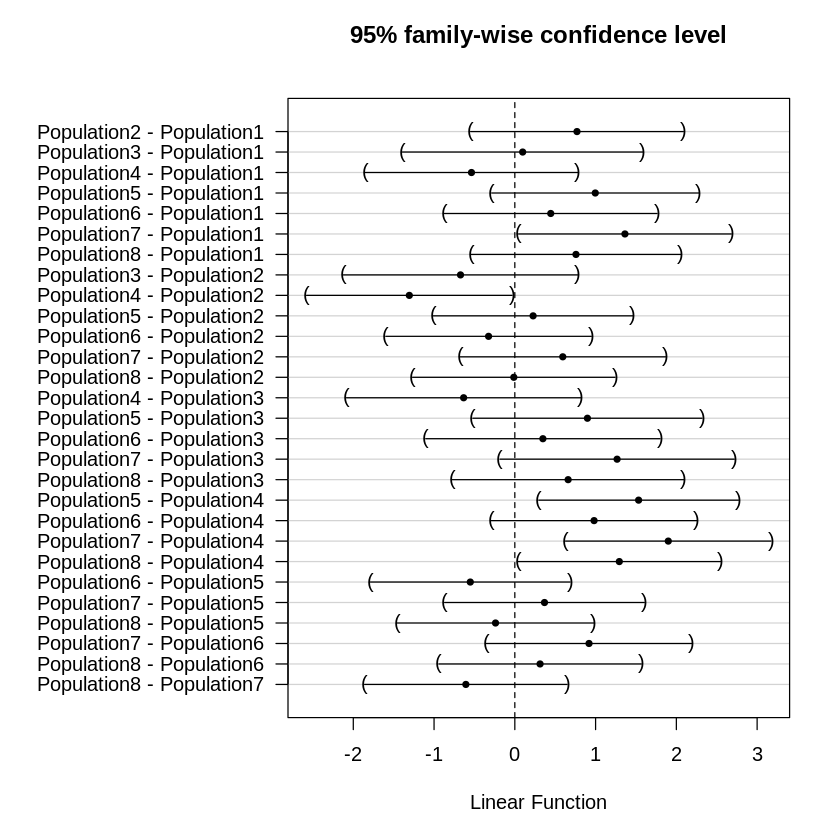

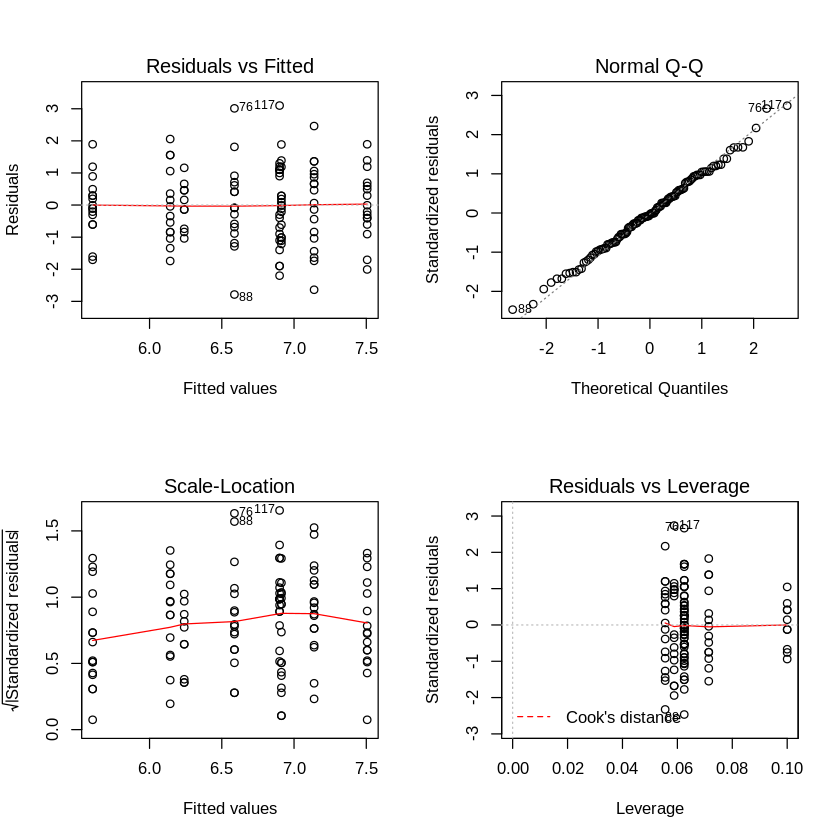

In [13]:
# fit a model of Petal_length and Population
mod2 <- aov(Petal_length ~ Population, data = morph)

# perform tests for all pairwise comparisons of populations
tukey <- glht(mod2, linfct = mcp(Population = "Tukey"))
# equivalent: tukey <- TukeyHSD(mod2, which = "Population")

# tabular output, mit "Bonferroni-Holm adjustment method"
summary(tukey, test = adjusted("BH"))

# graphical output
oldmar <- par()$mar # get default margins
par(mar = c(5.1, 12, 4.1, 2.1)) # give more left margin
plot(tukey)
par(mar = oldmar) # reset margins to default

# residual analysis for mod2
par(mfrow=c(2,2))
plot(mod2)
par(mfrow=c(2,2))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Which population pair shows the largest difference in `Petal_length`?

The `glht` function can do much more. It allows you to control which comparisons (tests) should be carried out. Each comparison is a separate test on the same dataset, therefore we have a **multiple testing problem**. The function `summary` on `glht` objects allows to set which p-value correction method should be used to correct for the multiple testing. The use of `glht` for specific contrasts requires the definition of a **contrast matrix**. It is a bit tricky to set up, but try to understand the following example, and you will be able to set specific contrasts that exactly match your research questions, while accounting for the multiple testing involved. These contrasts can be pairwise comparisons, but can also be more complex, as in the next example.

Let us now test whether `Petal_length` is significatly different between 
- Zeneggen and (Faldumalp and Grengiols)
- Zermatt and Niedergampel
- Zermatt and Zeneggen
- Zeneggen and Unterstalden
- Zeneggen and Grengiols

Follow these *rules* to create the **contrast matrix** *K*
- use sensible rownames for each contrast (will appear in the summary)
- columns correspond to the factor level (in the same order as `levels(<factor>)`, alphabetical by default)
- set the coefficient to `0` if a level is not used in a contrast
- use positive coefficients for levels in the first group and negative coefficients for levels in the second group
- levels in the first and second group *must* add up to 1 and -1, respectively
- each row *must* add up to zero

In [11]:
# define the contrast matrix for specific contrasts of interest
#              first  -  second                 Fal, Gib, Gre, Nie, Sim, Unt, Zen, Zer
K <- rbind("Population7 - Population1+Population3"= c(-1/2,   0,-1/2,   0,   0,   0,   1,   0),
           "Population8 - Population4"            = c(   0,   0,   0,  -1,   0,   0,   0,   1),
           "Population8 - Population7"            = c(   0,   0,   0,   0,   0,   0,  -1,   1),
           "Population7 - Population6"            = c(   0,   0,   0,   0,   0,  -1,   1,   0),
           "Population7 - Population3"            = c(   0,   0,  -1,   0,   0,   0,   1,   0))

# tabular output
# "single-step" is the default p-value correcton method
# The "BH" (Bonferroni-Holm) method is less conservative and more powerful than "bonferroni"
summary(specific <- glht(mod2, linfct = mcp(Population = K)), test = adjusted("single-step"))

# corresponding t-tests for comparison
t.test(morph$Petal_length[morph$Population %in% c("Population7")],
       morph$Petal_length[morph$Population %in% c("Population3","Population4")])
t.test(morph$Petal_length[morph$Population %in% "Population8"],
       morph$Petal_length[morph$Population %in% "Population4"])
t.test(morph$Petal_length[morph$Population %in% "Population8"],
       morph$Petal_length[morph$Population %in% "Population7"])
t.test(morph$Petal_length[morph$Population %in% "Population7"],
       morph$Petal_length[morph$Population %in% "Population6"])
t.test(morph$Petal_length[morph$Population %in% "Population7"],
       morph$Petal_length[morph$Population %in% "Population3"])


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: User-defined Contrasts


Fit: aov(formula = Petal_length ~ Population, data = morph)

Linear Hypotheses:
                                           Estimate Std. Error t value Pr(>|t|)
Population7 - Population1+Population3 == 0   1.3148     0.3789   3.470  0.00323
Population8 - Population4 == 0               1.2937     0.4066   3.182  0.00849
Population8 - Population7 == 0              -0.6062     0.4066  -1.491  0.42533
Population7 - Population6 == 0               0.9187     0.4127   2.226  0.10563
Population7 - Population3 == 0               1.2662     0.4705   2.691  0.03338
                                             
Population7 - Population1+Population3 == 0 **
Population8 - Population4 == 0             **
Population8 - Population7 == 0               
Population7 - Population6 == 0               
Population7 - Population3 == 0             * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.


	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% c("Population7")] and morph$Petal_length[morph$Population %in% c("Population3", "Population4")]
t = 5.2383, df = 27.761, p-value = 1.482e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.008338 2.304162
sample estimates:
mean of x mean of y 
  7.50625   5.85000 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Population8"] and morph$Petal_length[morph$Population %in% "Population4"]
t = 3.039, df = 26.974, p-value = 0.005224
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4202116 2.1672884
sample estimates:
mean of x mean of y 
  6.90000   5.60625 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Population8"] and morph$Petal_length[morph$Population %in% "Population7"]
t = -1.3619, df = 28.964, p-value = 0.1837
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.5167183  0.3042183
sample estimates:
mean of x mean of y 
  6.90000   7.50625 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Population7"] and morph$Petal_length[morph$Population %in% "Population6"]
t = 2.1539, df = 28.434, p-value = 0.03987
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04560124 1.79189876
sample estimates:
mean of x mean of y 
  7.50625   6.58750 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Population7"] and morph$Petal_length[morph$Population %in% "Population3"]
t = 3.6436, df = 23.761, p-value = 0.001305
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.5485989 1.9839011
sample estimates:
mean of x mean of y 
  7.50625   6.24000 


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
Compare results of the specific contrasts to the TukeyHSD results and the t-test results. 
- Why is there a difference between the specific contrasts results and the TukeyHSD results?
- Why is it better to specify specific contrasts rather than carry out multiple t-tests?

***
## 6 Multivariate Analyses

[Multivariate analysis](https://en.wikipedia.org/wiki/Multivariate_analysis) is a broad term that includes methods such as **Clustering analysis**, **Principal Component Analysis** (PCA), or **Linear Discriminant Analysis** (LDA).


### 6.1 The `d.mis` dataset
The `d.mis` dataset contains morphological measurements of 10 leaf characters in eight [*Dalbergia*](https://www.gbif.org/occurrence/gallery?country=MG&taxon_key=2968358) [rosewood](https://en.wikipedia.org/wiki/Rosewood) species from Madagascar. 

Let us read the data and get an overview. Note the use of `row.names` here: it automatically assigns row names of the resulting `data.frame` as the values stored in the column `ID`, and removes `ID` from the set of variables.

Before starting any analysis, always check that the data was read in correctly using `str`.

In [0]:
d.mis <- read.csv("https://raw.githubusercontent.com/scrameri/Umweltbiologie/master/Multivariate.csv", row.names = "ID")
str(d.mis)

cat("\nprint rownames\n")
print(head(rownames(d.mis)))

Since the dataset does not have too many variables, we can produce all pairwise plots using `ggparis` from the [*GGally*](https://cran.r-project.org/web/packages/GGally/index.html) package.

In [0]:
gp <- ggpairs(data = d.mis)
print(gp)

You see that some of the variables are highly *correlated* among each other. While this is a potential problem for linear models, this is not a problem for many multivariate techniques.

### 6.2 Data imputation
Most multivariate techniques cannot handle missing values. Bear this in mind when designing experiments and measuring data, and make sure to collect data that is *as complete as possible*.

One way to get around the missingness problem is to do a **Complete Case Analysis** by removing any individual with missing data. This may lead to loss of many individuals (most of the data) if missingness is distributed randomly accross individuals.

In the case of large datasets such as genetic datasets, one often has little data for some variables (genetic loci) for technical reasons. These loci might however be highly correlated to other loci with less missingness, and can thus be entirely removed from analysis without much information loss. 

However, before you remove any variable with one or more missing values, it makes sense to remove individuals that have few overall data, because that might 'save' many variables from being excluded at the expense of just a few excluded individuals.


Let us check how much missingness our dataset has, using a *self-written* **function** that computes the proportion of missing data.

Think of `x` as a vector of numbers, e.g. one column or one row in the dataset. The missingness is a function of `x`, and computed as the `sum` of `NA` values in `x` divided by the number of observations in `x`. Such a function is only slightly more complex than standard functions such as `mean`, but it could be an arbitrarily complex function with many intermediate steps and variables.

In [0]:
# define the function that computes the percentage of missing values in a numeric vector
missingness <- function(x) {sum(is.na(x))/length(x)}

#### The apply function family
Let us now apply this function to all columns, and all rows, to identify how much missingness these have. For such tasks, we use the `apply` familiy of functions. Have a look at the manuals for `apply`, `sapply`, `lapply` and `tapply`, these can be quite useful and save quite a lot of coding.

The function `apply` takes a `data.frame` `X` as input, a `MARGIN` specification, and *applies* the function specified by the `FUN` argument to *each* element of the data subset defined by `MARGIN`. The output of `apply` can be a single value, a named vector or a matrix, depending on the `MARGIN` and `FUN` employed.

`MARGIN` can be set as
- `1` for "apply function over each row"
- `2` for "apply function over each column"
- `c(1,2)` for "apply function over rows and columns"


By the way: any further arguments that are taken by `FUN` can be passed as additional arguments, as indicated by the `...` in the `apply` function definition. If you wanted to apply the `mean` function to get column means, you could set `FUN = mean, na.rm = TRUE` to override the default behaviour that returns `NA` if there are missing values.

In [0]:
print(apply(X = d.mis[,-c(1:2)], MARGIN = 2, FUN = mean))

In [0]:
print(apply(X = d.mis[,-c(1:2)], MARGIN = 2, FUN = mean, na.rm = TRUE))

You can now combine `apply` with the self-written function `missingness` as follows (once over individuals, once over variables):

In [0]:
mis.rows <- apply(X = d.mis[,-c(1:2)], MARGIN = 1, FUN = missingness) # MARGIN = 1 computes over *rows*
mis.cols <- apply(X = d.mis[,-c(1:2)], MARGIN = 2, FUN = missingness) # MARGIN = 2 computes over *columns*

# this sorts the individual and variable missingness and shows the 10 instances with highest missingness
cat("\nmissingness per individual\n")
print(head(sort(mis.rows, decreasing = TRUE), n = 10))

cat("\nmissingness per variable\n")
print(head(sort(mis.cols, decreasing = TRUE), n = 10))

We see that one variable has nearly 10% missing data, while two individuals have 20% missingness. Excluding one out of 10 variables would throw away much more information than excluding two out of 126 individuals that likely contribute to the observed missingness in `leaflet.lower.hairy`. Before removing the two individuals, check what you are losing in terms of observations per `Species`.

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- To which `Species` do the two individuals with high missingness belong?
- Can we remove these individuals without losing data for a given `Species`? If yes, create a data.frame where these individuals are excluded.

In [0]:
# write your code here

If the data table still contains missing values after removing individuals or/and variables with little data, these can be replaced by some unbiased values via **data imputation**. There are many sophisticated methods to do this. One simple method is to impute **variable means**.

BEWARE: always bear in mind how much missingness your data has. Everitt & Hothorn (2011) write: 
>"Imputing an observed variable mean for a variable with missing values preserves the observed sample means but distorts the covariance matrix [...], biasing estimated variances and covariances towards zero. [...] one should always bear in mind that the imputed values are not real measurements. We do not get something for nothing! And if there is a substantial proportion of individuals with large amounts of missing data, one should clearly question whether any form of statistical analysis is worth the bother."


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you write a function that replaces all `NA` values in a vector by the `mean` of that vector? Hint: use the `return` function to return the imputed vector at the end of your function.
- Can you apply that function to all variables with missing data, and assign the output to a `data.frame` named `d.imp`? Hint: apply returns a `matrix` rather than a `data.frame`.

In [0]:
# Write your function and application here

# Test your function on this test vector (yourfunction(tes))
test <- c(1.1,3.2,6.4,NA,3.6)
print(mean(test, na.rm = TRUE))

# Apply your function to all numeric columns of d.mis, and assign the output to d.imp

***
### 6.3 Data Aggregation
It may be of interest to compute a **summary statistic** such as the `median` of *all* numeric variables *per species*. This would allow for a quick comparison between species.

Of course, one could do subsets of the dataset for each species to calculate the summary statistic, or apply the `tapply` function for each variable, but that takes lines of code for each species or variable, respectively. There is an even more powerful function to do such calculations in *one* line of code. Meet the `aggregate` function: it takes a `data.frame` of numeric variables as input, and applies a specified function `FUN` to *subsets* of each variable. The subsets are defined by the `by` argument, and can include one or more factor variables, which *have* to be specified as a *list*.


In [0]:
# aggregate by one factor
aggregate(x = d.mis[,-c(1,2)], by = list(d.mis$Species), FUN = median, na.rm = TRUE)

# aggregate by two or more factors
aggregate(x = d.mis[,-c(1,2)], by = list(d.mis$Species, d.mis$Region), FUN = median, na.rm = TRUE)

***
### 6.4 Plot multivariate data
There are a number of special plots designed to visualize large multivariate datasets. One of them is the **Co-Plot**. A Co-Plot displays scatterplots of two variables, but separately for different states of up to two other continuous or discrete variables.

The `coplot` function takes the variables to be displayed as a formula:
- `coplot(y ~ x | separated_by_x + separated_by_y, data = data)`


In [0]:
# color vector for 8 species
col <- c("#A6CEE3","#72B29C","#4F9F3B","#E93E3F","#FDAC4F","#D1AAB7","#A99099","#B15928")

# Co-Plot
coplot(leaflet.shape1 ~ leaflet.length | Species + Region, data = d.mis, 
       col = col[d.mis$Species], pch = 19)  # note the use of col
legend("topright",levels(d.mis$Species),pch = 19, col = col, 
       xpd = TRUE, bty = "n", cex = 0.7)

Now we already see that Species1, 2, 3 and 5 are similar with respect to leaflet.length and leaflet.shape1, or that Species 6 has by far the longest leaflets. But what about overall similarity based on all the data (could be thousands of variables, think e.g. of next-generation sequencing data)? This is a **dimensionality problem**, which is where **Principal Components Analysis** (PCA) can help.

PCA can only handle **numeric** data (continuous or discrete). Let us therefore subset the numeric variables from the imputed dataset.

In [0]:
numericvars <- names(d.mis)[-c(1:2)]
factorvars <- names(d.mis)[1:2]

# define impute function
impute <- function(x) {x[is.na(x)] <- mean(x, na.rm = TRUE) ; return(x)}

# apply impute function and assign data.frame with factor variables
d.imp <- data.frame(d.mis[,factorvars], apply(d.mis[,numericvars], 2, impute))

# subset data.frame to include numeric variables only
d.pca <- d.imp[,numericvars]

### 6.5 Principal Component Analysis (PCA)

Before PCA is carried out, the dataset is sometimes transformed. Two transformations are important here:
- centering `x <- x-mean(x)`
- scaling `x <- x/sd(x)`

In PCA, all variables are usually **centered** around zero, by subtracting their mean. The question is whether one should **scale** the variables to unit variance, that is, divide them by their standard deviation. 

Rules: 
- if you deal with variables that measure different aspects on *different scales* such as size and shape, these variables will have very *different variance*. If you want to normalize for the different scale, it is very important to scale the variables to unit variance.
- remove any variable with *zero* variance, otherwise prcomp will throw an error.

In [0]:
print(sort(apply(X = d.pca, MARGIN = 2, FUN = var), decreasing = TRUE))


Every variable has variation, this is needed for `prcomp` to work. If one or more variables have zero variance between individuals, e.g. after subsetting your data, the `prcomp` command will issue an error. In that case, we would need to **exclude any variable with zero variance** before subjecting the data to PCA.

However, `leaflet.area` has 10^10 times the variance of `leaflet.shape2`. That ist due to the *scale* of measurement, not due to the *amount of information* that these variables contain. For example, there could be significant differences between groups of individuals in a variable measured in *meters*, but small differences between groups of individuals in a variable measured in *millimetres*. PCA on such unscaled data will construct principal components that maximize the spread (variation) in a certain direction in multivariate space, and variables measured on a meter scale will likely not load the principal components (regardless of their high information content) if there are other variables measured at the millimeter scale that contribute variance in the hundreds. Since we have variables measured at different scales, we will center and *scale* the dataset before PCA as follows.

In [0]:
# Principal Component Analysis (PCA)
pca <- prcomp(x = d.pca, center = TRUE, scale. = TRUE) # don't forget the "." after scale!
# prcomp(x = scale(d.pca, center = TRUE, scale = TRUE), center = FALSE, scale. = FALSE)' # equivalent

# Structure of objects of class 'pca'
str(pca)

In `pca` objects, there are three important results to look at:
- `$x` gives the **PCA scores**, the coordinates of each individual in PCA space
- `$sdev` contains information on the squared variance (**standard deviation**) of each principal component (PC)
- `$rotation` contains **variable loadings**, the information on how much each original variable contributs to each PC

#### 6.5.1 The PCA scores
Let us take a look at the PCA scores. Note why it was worth to set the `ID` variable as rownames.

In [0]:
head(pca$x, n = 3)

If you have more individuals than variables, the PCA scores table has dimension [number of individuals, number of variables]. If you had less individuals than variables, the dimensions would be [number of individuals, number of individuals].
  
In total, the information contained in `pca$x` is equivalent to the information in the input data. The difference between the PCA scores and the original data is that the first few PCs contain most of the variation (i.e., information), whereas the informative variation may be scattered throughout all variables in the original data. This **reduction of dimensionality** is one important goal of PCA.

In [0]:
dim(pca$x)

#### 6.5.2 The Principal Component variance
In PCA, we want to know the *fraction of variance* contained in (explained by) each principal component. Remember from your statistics course that variance is squared standard deviation. The fraction is simply computed as the component variance divided by the total variance.

In [0]:
# Explained variance
# print(pca$sdev^2) # equivalent to apply(X = pca$x, MARGIN = 2, FUN = var)

# Fraction of explained variance
print(var <- pca$sdev^2 / sum(pca$sdev^2)) # magical formula to get PC variances

# Assign names to the variance vector
names(var) <- paste0("PC", 1:length(var)) # makes a named vector

# Cumulative fractions of variance should add up to 1
print(cumsum(var))

Explained variance is often presented as a **Screeplot**, which is just a barplot of component variances:


In [0]:
# This plot helps to see which PCs contain a lot of information, i.e. are biologically meaningful.
barplot(100*var, xlab = "Principal Component", ylab = "Component Variance (%)")

# This plot helps to decide which PCs explain enough variance to satisfy a certain criterion, e.g. 80% of total variance.
barplot(100*cumsum(var), xlab = "Principal Component", ylab = "Cumulative Component Variance (%)")


#### 6.5.3 Variable loadings

The variable loadings are the contribution of each original variable to each Principal Component. These are stored in the rotation matrix `$rotation`. I've written a function that vizualizes the relative importance of each variable to each principal component.

In [0]:
loadings <- data.frame(pca$rotation)

loadingplot <- function(x, component = 1, abs = TRUE) {
  # take absolute values if indicated
  if (abs) {x <- abs(x)}

  # plot
  c <- x[,component]

  ggplot(x, aes(x = seq_along(c), xend = seq_along(c),
                y = 0, yend = c)) +
    geom_segment() +
    geom_text(aes(x = seq_along(c), y = c, 
                  label = rownames(x)), size = 3) +
    scale_x_continuous(breaks = seq_along(c), 
                     labels = seq_along(c)) +
    labs(x = "PC Component", 
         y = paste(ifelse(abs, "Absolute ", ""), "PC Loading (Coefficient)")) +
    ggtitle(paste("Component", component)) +
    theme_bw()
}

loadingplot(loadings, 1, abs = TRUE)
loadingplot(loadings, 2, abs = TRUE)
loadingplot(loadings, 3, abs = TRUE)

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What do the first three components 'measure'?

#### 6.5.4 The relationship between variable loadings and variable scores
You can think of the PC variable loadings as the **coefficients** that fit the input data to a PC score. In other words: 
> the PC axes are the *linear combination* of the *data vectors* (rows containing the measurements per individual) with the loadings as coefficients.

The larger the absolute coefficient, the larger the contribution of that variable to the principal component. If a large coefficient is positive, individuals with high values in that variable will have a positive PC axis score.

In [0]:
# define the input to PCA (the scaled and centered variables)
pca.input <- as.matrix(scale(d.pca, center = TRUE, scale = TRUE))

# from the rotation matrix, calculate the coordinate of SH031 on PC1
cat("input data\n")
print(pca.input["SH156",])
cat("\nPC 1 loadings\n")
print(pca$rotation[,1])

# calculate by hand
cat("\nby hand:\n")
print(1.606827*0.3319507 + 2.988947*0.3742269 + 3.849139*0.3881035 + 4.332554*0.3659823 + -1.118697*-0.2518057 + -1.703997*-0.3317078 + -1.526139*-0.3272454 + -2.532783*-0.3065936 + 1.356265*0.1160678 + -2.155491*-0.2778463)

# calculate one PC score by scalar multiplication
cat("\nby scalar multiplication:\n")
print(pca.input["SH156",] %*% pca$rotation[,1])

# calculate all PC scores by matrix multiplication
cat("\nidentity test:\n")
scores <- pca.input %*% pca$rotation
print(all.equal(scores, pca$x)) # if TRUE, you did it!

#### 6.5.5 Mathematics of PCA
**Component variances** in a PCA on the unscaled data are the same as the **eigenvalues** of the [**covariance matrix**](https://en.wikipedia.org/wiki/Covariance_matrix) of that data.

If the data is scaled (`scale. = TRUE`) before PCA, the component variances are the same as the eigenvalues of the [**correlation matrix**](https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices) of that data.

In [0]:
# eigenvalues
cat("Standard deviations of principal components\n")
print(pca$sdev^2)

cat("Eigenvalues of the scaled covariance matrix\n")
print(eigen(cov(scale(d.pca)))$value)

cat("Eigenvalues of the correlation matrix\n")
print(eigen(cor(d.pca))$value)

**PCA loadings** (rotation matrix) on a PCA of some data are the same as the **eigenvectors** of the covariance matrix (`scale. = FALSE`) or correlation matrix (`scale. = TRUE`) of that data. The sign can be the opposite but that does not matter.

In [0]:
# eigenvectors
cat("Principal component loadings\n")
print(head(pca$rotation, n = 3))

cat("\nEigenvectors of the scaled covariance matrix\n")
print(head(eigen(cov(scale(d.pca)))$vectors, n = 3))

cat("\nEigenvectors of the correlation matrix\n")
print(head(eigen(cor(d.pca))$vectors, n = 3))

#### 6.5.6 Visualizing PCA results
Finally, we want to see the famous scatterplot of the first PCA components, nicely colored by some covariates. The `factoextra` package offers handy functions to plot both the PCA loadings and the PCA scores. Since it has many dependencies, the installation takes a while...

In [12]:
need.pckg <- c("factoextra") # needed for this script
if (any(!need.pckg %in% installed.packages())) {
  for (i in need.pckg[!need.pckg %in% installed.packages()]) {
    cat("installing", i, "...\n")
    install.packages(i)
  }
}
library(factoextra)

installing factoextra ...


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘data.table’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘carData’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘corrplot’, ‘viridis’, ‘car’, ‘ellipse’, ‘flashClust’, ‘leaps’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘ggrepel’


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [0]:
## PCA variable loadings (here displayed for PC 1 and 2)
fviz_pca_var(pca, col.var = "contrib", axes = c(1,2),
             gradient.cols = c("gray25", "gray45", "red"), repel = TRUE)

## PCA scores (here for PC 1 and 2, with 90% confidence ellipses around Species)
fviz_pca_ind(pca, axes = c(1, 2),
             habillage = d.imp$Species, # habillage is the factor used for colors
             palette = col,
             addEllipses = TRUE, ellipse.level = 0.9, # sets size of ellipses
             ellipse.alpha = 0.5,  # sets ellipse transparency 
             label = "ind", labelsize = 1, # use label = "none" to omit labels
             repel = TRUE) +
  coord_fixed() # sets the same scale for both components

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
By looking at these visualizations only:
- Which variables are highly correlated? Verify using `cor` or `cor.test`.
- Which `Species` has the longest leaves and largest leaflets?
- Which `Species` have hairy leaves and leaflets?

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
Carry out a nested PC analysis within the morphologically similar species 1, 3, 4 and 5, and dispaly the results.
- Can these species be differentiated based on these leaf characters? If so, by which variables?

In [0]:
# subset
d.pca2 <- d.pca[d.imp$Species %in% c("Species1","Species2","Species3","Species5"),]
d.imp2 <- d.imp[d.imp$Species %in% c("Species1","Species2","Species3","Species5"),]

# PCA
pca2 <- prcomp(d.pca2, center = TRUE, scale. = TRUE)

# PCA screeplot
var2 <- pca2$sdev^2/sum(pca2$sdev^2) 
barplot(100*var2, xlab = "Principal Component", ylab = "Component Variance (%)")

# PCA loadings
fviz_pca_var(pca2, col.var = "contrib", axes = c(1,2),
             gradient.cols = c("gray25", "gray45", "red"), repel = TRUE)

# PCA scores of PC1 and PC2
fviz_pca_ind(pca2, axes = c(1, 2),
             habillage = d.imp2$Species, # habillage is the factor used for colors
             palette = col,
             addEllipses = TRUE, ellipse.level = 0.9, # sets size of ellipses
             ellipse.alpha = 0.5,  # sets ellipse transparency 
             label = "ind", labelsize = 1, # use label = "none" to omit labels
             repel = TRUE) +
  coord_fixed() # sets the same scale for both components

***
### 6.6 Linear Discriminant Analysis (LDA)
Linear discriminant analysis is used for **classification** of a set of continuous variables. This is a case where the response variable is a `factor` level. The [MASS](https://cran.r-project.org/web/packages/MASS/MASS.pdf) package implements LDA.

**Note** the use of `~ .` to denote "all remaining variables in the data".

In [0]:
## Include species factor
d.lda <- data.frame(Species = d.mis$Species, d.pca)

## Perform LDA
library(MASS)
lda1 <- lda(Species ~ ., data = d.lda)

Why is LDA useful? You can use the *fitted* model to *predict* the class of any new individual:

In [0]:
# new individual to classify
ind <- 59 # can be an individual that was not used for the fitting!
print(totest <- d.lda[ind,-1])
cat("\nTrue species:\n")
print(d.lda[ind,1])

# predict class of new individual
cat("\nPredicted species:\n")
print(predict(lda1, newdata = d.lda[ind,-1])$class)

***
## References
- G. W. Oehlert (2000) A first course in design and analysis of experiments. Freeman & Co.
- B. Everitt & T. Hothorn (2011) An Introduction to Applied Multivariate Analysis with R. Springer.

### Links
ANOVA Teaching Notes by Dr. Lukas Meier, Senior Scientist at the Seminar for Statistics, ETH Zurich
- https://stat.ethz.ch/~meier/teaching/anova/